# Data Curation

Today we'll begin our scrubbing and curating our dataset by focusing on a subset of the data: Home Appliances.

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

## Imports and environment setup

In [13]:
# imports

import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt

from utils.items import Item

In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Load data

Instead of loading the entire data, we will load a subset and perform our experiments on it before scaling it up to the entire dataset


In [4]:

dataset = load_dataset(
    "McAuley-Lab/Amazon-Reviews-2023",  # dataset identifier (from Hugging Face Hub)
    f"raw_meta_Appliances",             # specific subset of the dataset
    split="full",                       # which split of the dataset we want (train/test/full.)
    trust_remote_code=True             
)


In [5]:
dataset

Dataset({
    features: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
    num_rows: 94327
})

## EDA

In [6]:
print(f"Number of Appliances: {len(dataset):,}")

Number of Appliances: 94,327


Investigating a single datapoint from the dataset. Each point in the dataset is a dictionary

In [7]:
dataset[0].keys()

dict_keys(['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author'])

In [8]:
import random

datapoint = dataset[random.randint(0,len(dataset)-1)]

print(f'Title: {datapoint["title"]} \n\nType: {type(datapoint["title"])}\n\n')
print(f'Description: {datapoint["description"]}\n\nType: {type(datapoint["description"])}\n\n')
print(f'Features: {datapoint["features"]}\n\nType: {type(datapoint["features"])}\n\n')
print(f'Details: {datapoint["details"]}\n\nType: {type(datapoint["details"])}\n\n')
print(f'Price: {datapoint["price"]}, \n\nType: {type(datapoint["price"])}\n\n')

Title: 285976 Drum Baffle (11.3"x2.4"x2.6") fit for Whirl-pool Washer-Replacement 8182233,3Pack 

Type: <class 'str'>


Description: ['This baffle (part number 285976) is for washers.', 'Fit Model', 'GHW9400PT4, GHW9400PW0, GHW9400PW1, GHW9400PW2, GHW9400PW3, GHW9400PW4, GHW9400SU0, GHW9460PL0, GHW9460PL1, GHW9460PL2, GHW9460PL3, GHW9460PL4, GHW9460PW0, GHW9460PW1, GHW9460PW2, GHW9460PW3, GHW9460PW4, KHWS01PMT3, KHWS01PWH0, KHWS02RMT0, KHWS02RMT1, KHWS02RMT2,KHWS02RMT3, KHWS02RWH0, KHWS02RWH1, KHWS02RWH2, KHWS02RWH3, KHWV01RSS0, WFW9200SQ00, WFW9200SQ01, WFW9200SQ02, WFW9300VU02, WFW9400SB00,WFW9400SB01, WFW9400ST00, WFW9400ST01, WFW9400SU00, WFW9400SU01, WFW9400SW00, WFW9400SW01, WFW9400SZ00, WFW9400SZ01, WFW9400VE01, WFW9500TC00, When the washer Unusual noises, not washing properly, you can replace this part. This part is also known as a washing machine drum baffle, tub baffle, drum vane, tub vane.']

Type: <class 'list'>


Features: ['285976 Baffle Front Load Washer Drum', 'Replaces

Lets check how many have datapoints have the price feature. This is to check the distribution of the data. 

In [9]:
count = 0
for datapoint in dataset:
    try:
        price = float(datapoint['price'])
        if price > 0:
            count += 1
    except ValueError:
        pass

print(f'There are {count:,} datapoints with prices which is {(count/len(dataset))*100:,.2f}% of the data')

There are 46,726 datapoints with prices which is 49.54% of the data


For the items with prices, let us understand the distribution of the data for the prices. Additionally, we will also try to understand the distribution of the text data based on its length of contents which includes the title, description, features and details of the product. 

In [10]:
prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint['price'])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError:
        pass

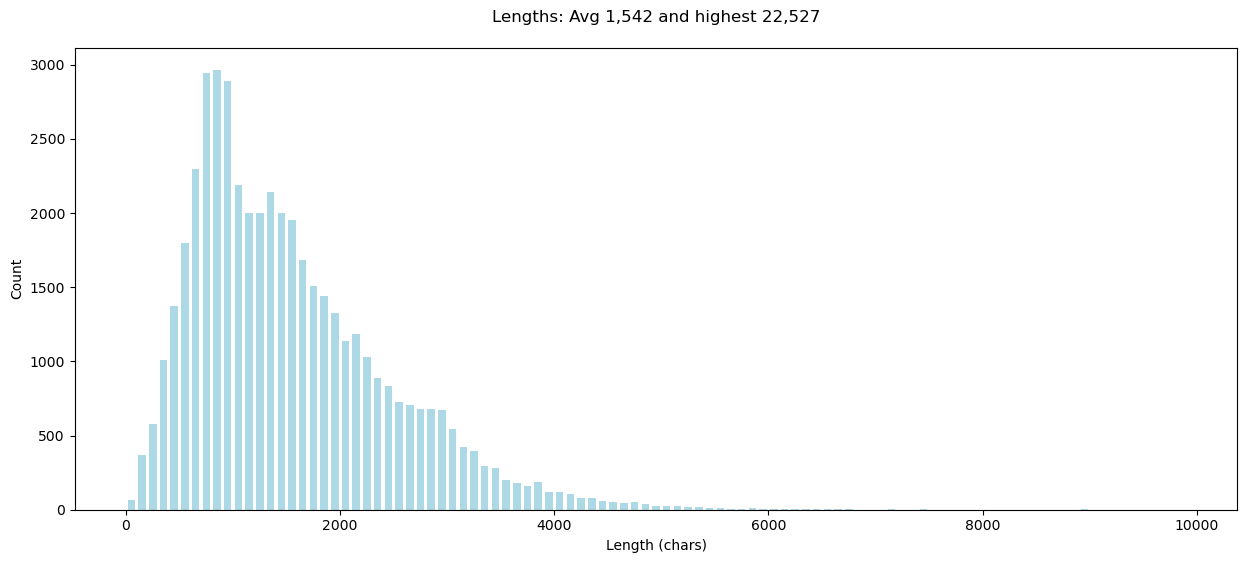

In [11]:
# Plot the distribution of lengths

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 10000, 100))
plt.show()

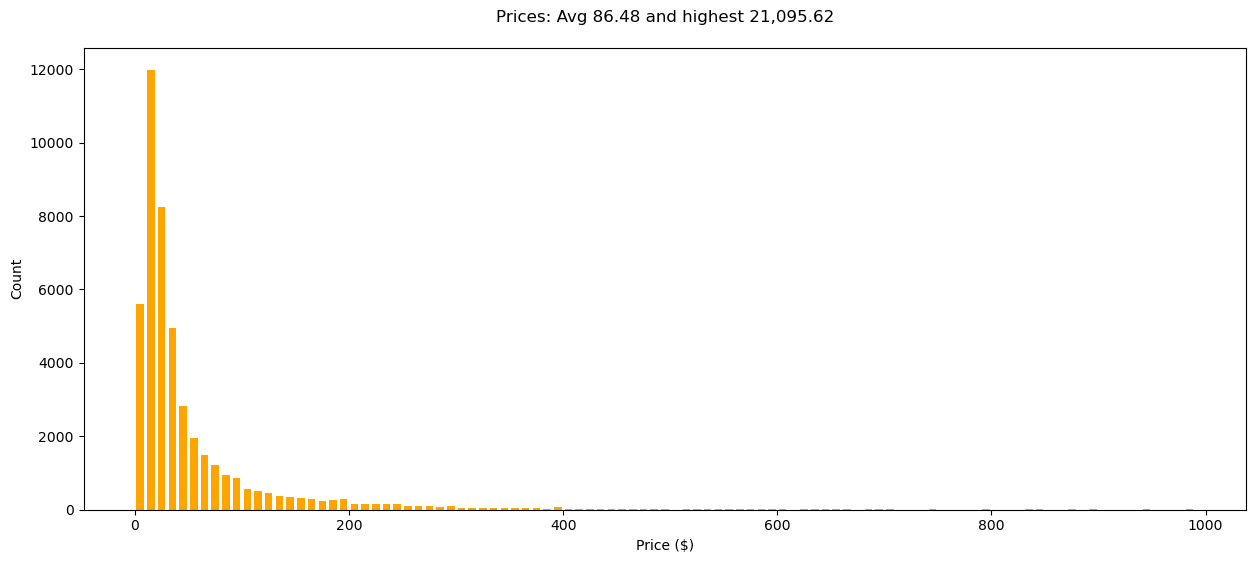

In [12]:
# Plot the distribution of prices

plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [32]:
items = []

for datapoint in dataset:
    try:
        price = float(datapoint['price'])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError:
        pass


In [38]:
print(f'There are {len(prices)} datapoints with prices out of which {len(items)} items which has enough useful information that can be used for training ')

There are 46726 datapoints with prices out of which 29191 items which has enough useful information that can be used for training 


In [39]:
items[0]

<WD12X10327 Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces AP4980629 PS3486910 1811003 = $8.99>